# Grama: Fitting Univariate Distributions

*Purpose*: As we've seen through studying a lot of datasets, many physical systems exhibit variability and other forms of uncertainty. Thus, it is beneficial to be able to *model* uncertainty using distributions. In this two-part exercise, we'll first learn how to fit a distribution for a *single* quantity, then learn how to deal with *multiple* related quantities.

In the final exercise `e-grama08-duu` we'll see how to use a distribution model to do useful engineering work.


## Setup


In [1]:
import grama as gr
DF = gr.Intention()
%matplotlib inline

For this exercise, we'll study a dataset of observations on die cast aluminum parts.


In [2]:
## NOTE: No need to edit
from grama.data import df_shewhart


# Why fit a distribution?

Before we start fitting distributions: *Why* would we ever want to fit a distribution?

As we've seen from studying a large number of datasets, most engineering data exhibit [variability](https://zdelrosario.github.io/evc-course/exercises_solution/d08-e-stat02-source-solution.html). If the variability is real, it can have real impacts on the engineering systems we design.

For instance, here's a dataset of realized aluminum tensile strength values:


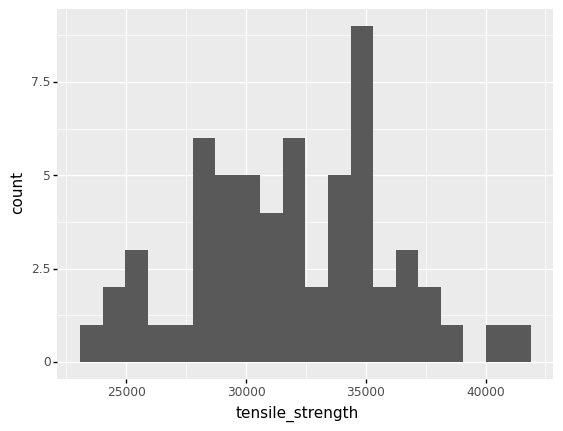

<ggplot: (8758216577434)>

In [3]:
# NOTE: No need to edit; run and inspect
(
    df_shewhart
    >> gr.ggplot(gr.aes("tensile_strength"))
    + gr.geom_histogram(bins=20)
)

Clearly, these data exhibit variability---they do not take a single value.


## Dangers of assuming the mean

Why don't we just take the mean of `tensile_strength` and use that for design? It turns out this approach is *very dangerous* when safety is a consideration. Let's take a look at the tensile strength of an aluminum alloy.


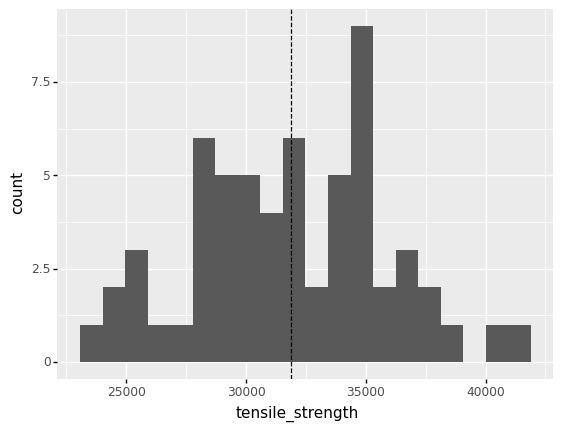

<ggplot: (8758214365901)>

In [4]:
# NOTE: No need to edit; run and inspect
(
    df_shewhart
    >> gr.ggplot(gr.aes("tensile_strength"))
    + gr.geom_histogram(bins=20)
    + gr.geom_vline(
        data=df_shewhart
        >> gr.tf_summarize(tensile_strength=gr.mean(DF.tensile_strength)),
        mapping=gr.aes(xintercept="tensile_strength"),
        linetype="dashed",
    )
)

Clearly, values of `tensile_strength` tend to land both above and below the mean. But what ramifications does this have for engineering design?


### __q1__ What fraction of `tensile_strength` is below the mean?

Compute the fraction of observations in `df_shewhart` where `tensile_strength < mean(tensile_strength)`. Answer the questions under *observations* below.


In [5]:
## TASK: Compute the fraction of values where tensile_strength < mean(tensile_strength)
(
    df_shewhart
    >> gr.tf_summarize(
        frac=gr.pr(DF.tensile_strength < gr.mean(DF.tensile_strength))
    )
)

,frac
0,0.5


*Observations*

For these questions, assume the variability in `tensile_strength` is real; that is, the variability is not simply due to measurement error.

- What fraction of observations have `tensile_strength < mean(tensile_strength)`?
  - I find that `frac == 0.5` (i.e. 50%)
- Suppose a design assumed `mean(tensile_strength)` as the design stress; that is, every part would be subject to a stress equal to `mean(tensile_strength)`. The fraction you computed above would be the fraction of parts that would fail. Would this failure rate be acceptable for any engineering system involving human safety?
  - Absolutely not; a failure rate of 50% would be completely unacceptable for any application involving human safety.


Rather than just assume a fixed value for `tensile_strength`, we can model it as uncertain and design around that uncertainty. We'll learn how to make these kinds of engineering decisions in a future exercise; for now, let's


## Random variables

Clearly `tensile_strength` does not take a single value; therefore, we should think of `tensile_strength` as a *random variable*. A random variable is a mathematical object that we can use to model an uncertain quantity. Unlike a *deterministic variable* that has one fixed value (say $x = 1$), a random variable can take a different value each time we *observe* it. For instance, if $X$ were a random variable, and we used $X_i$ to denote the value that occurs on the $i$-th observation, then we might see a sequence like

$$X_1 = 1, X_2 = -3, X_3 = 1, X_4 = 5, \dots$$

What counts as an *observation* depends on what we are using the random variable to model. Essentially, an observation is an occurrence that gives us the potential to "see" a new value. 

Let's take a look at the `tensile_strength` example to get a better sense of these ideas.


For the `tensile_strength`, we saw a sequence of different values:

In [6]:
## NOTE: No need to edit
(
    df_shewhart
    >> gr.tf_head(4)
)

,specimen,tensile_strength,hardness,density
0,1,29314,53.0,2.666
1,2,34860,70.2,2.708
2,3,36818,84.3,2.865
3,4,30120,55.3,2.627


Every time we manufacture a new part, we perform a sequence of manufacturing steps that work together to "lock in" a particular value of `tensile_strength`. Those individual steps tend to go slightly differently each time we make a part (e.g. an operator calls in sick one day, we get a slightly more dense batch of raw material, it's a particularly hot summer day, etc.), so we end up with different properties in each part.

Given the complicated realities of manfacturing, it makes sense to think of an *observation* as being one complete run of the manufacturing process that generates a particular part with its own `tensile_strength`. This is what the `specimen` column in `df_shewhart` refers to; a unique identifier tracking individual runs of the complete manufacturing process, resulting in a unique part.


```{admonition} Nomenclature: A *realization* is like a single roll of a die
Some nomenclature: When we talk about random quantities, we use the term *realization* (or *observation*) to refer to a single event that yields a random value, according to a particular distribution. For instance, a single manufactured part will have a realized strength value. If we take multiple realizations, we will tend to see different values. For instance, we saw a large amount of variability among the realized `tensile_strength` values above.

A single realization tells us very little about how the distribution tends to behave, but a set of realizations (a *sample*) will give us a sense of how the random values tend to behave *collectively*. A distribution is a way to model that collective behavior.
```

## A distribution defines a random variable

As we saw in `e-stat04-distributions`, we can use distributions to quantitatively describe an uncertain quantity. **A distribution defines a random variable**. We say that a random variable $X$ is *distributed according to* a particular density $\rho$, and we express the same statement mathematically as

$$X \sim \rho.$$

We learned how to compute useful quantities using distributions in `e-stat04-distributions`; in the rest of this exercise, we'll learn how to *fit* a distribution in order use information from a dataset to model observations from the physical world.


# The steps to fitting

1. Check for *statistical control*
2. Select candidate distributions
3. Fit and assess


# 1. Check for *statistical control*

Sometimes the variability we see in a dataset can be *explained*; in this case, we shouldn't just model it as random---we should work to understand *why* we saw that variability, and try to eliminate that source of variation. As we saw in [`e-stat06-spc`](https://zdelrosario.github.io/evc-course/exercises_solution/d22-e-stat06-spc-solution.html), we can use *control charts* to hunt for explainable sources of variability.

> If we find no explainable sources of variability in a dataset, we can *provisionally* declare that the data are under *statistical control*, and model the variability as random.


### __q2__ Assess statistical control

Assess the state of statistical control of `tensile_strength` using an X-bar and S chart. Answer the questions under *observations* below.

*Hint*: You did this at the end of [e-stat06-spc](https://zdelrosario.github.io/evc-course/exercises_solution/d22-e-stat06-spc-solution.html); see that exercise for a refresher if you need it.


/home/zach/Git/py_grama/grama/tran_pivot.py:570: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zach/Bin/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/zach/Bin/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/zach/Bin/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


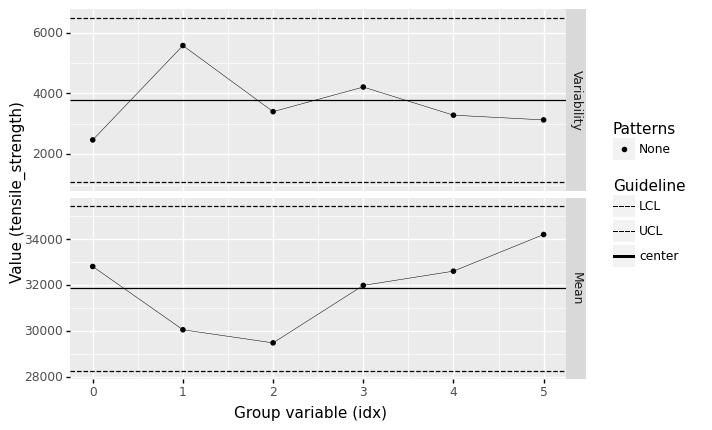

<ggplot: (8758214107194)>

In [7]:
## TASK: Assess statistical control with an Xbar and S chart
(
    df_shewhart
    >> gr.tf_mutate(idx=DF.index // 10)
    >> gr.pt_xbs(group="idx", var="tensile_strength")
)

*Observations*

- What assumptions did you need to make to construct a control chart?
  - I had to assume that the observations were reported in their run-order. I also chose to group in batches of `n_batch = 10` to help ensure the batch means follow the CLT.
- Does `tensile_strength` seem to be under statistical control?
  - According to a batch size of `n_batch = 10`, yes.


If the data seem to be under statistical control, then we can model the measured value as random. For this exercise, we'll assume that `tensile_strengh` is under statistical control and proceed with modeling.


# 2. Select candidate distributions

Once we've decided to proceed modeling a quantity as random, we next need to select candidate distributions to represent the quantity. This is a process that should involve critical thinking about the physical quantity.

## (Short) list of distributions

The following is a short list of distributions, along with a short description for each. The description information is helpful for choosing candidate distributions.

| Distribution | Name | Description |
|---|---|---|
| Normal (Gaussian) | `"norm"` | symmetric; infinite extent |
| Lognormal | `"lognorm"` | asymmetric; semi-infinite (positive) |
| Uniform | `"uniform"` | flat, bounded |
| Beta | `"beta"` | flexible shape, bounded |
| Weibull | `"weibull_min"` | asymmetric; semi-infinite (positive) |

For a longer list of supported distributions, see the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/stats.html) for continuous distributions.


### __q3__ Select reasonable distributions for `tensile_strength`

From the list above, select a few *reasonable* distributions that could describe the `tensile_strength`.

List the distributions below:

- Lognormal - strength is non-negative
- Weibull - strength is non-negative


# 3. Fit and assess

Now that we've selected reasonable distributions for our quantity, we can fit and assess the distributions.


## Grama tools for fitting

Grama provides two ways to fit a distribution:

| Verb | Purpose |
|------|---------|
| `gr.marg_mom()` | Fit a distribution based on a handful of statistics, e.g. mean and variance |
| `gr.marg_fit()` | Fit a distribution using multiple observations, e.g. `df_shewhart.tensile_strength` |

Let's learn how to use both!


### __q4__ Fit a normal distribution

Complete the arguments for both `gr.marg_mom()` and `gr.marg_fit()` below to fit a normal distribution for the `tensile_strength`.

*Hint 1*: Remember the table above (`Short list of distributions`) lists the string names for a set of distributions.

*Hint 2*: Remember to use the documentation to learn how to call a new function!


In [8]:
## TASK: Complete the arguments for the two functions below
mg_mom = gr.marg_mom(

    "norm", 
    mean=df_shewhart.tensile_strength.mean(),
    var=df_shewhart.tensile_strength.var(),
)

mg_fit = gr.marg_fit(

    "norm",
    df_shewhart.tensile_strength,
)

## NOTE: No need to edit; this will run when you complete the task
print(mg_mom)
print(mg_fit)

(+0) norm, {'mean': '3.187e+04', 's.d.': '3.996e+03', 'COV': 0.13, 'skew.': 0.0, 'kurt.': 3.0}
(+0) norm, {'mean': '3.187e+04', 's.d.': '3.963e+03', 'COV': 0.12, 'skew.': 0.0, 'kurt.': 3.0}


## QQ plots

A [QQ plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) is a statistical tool for assessing the quality of a distribution fit. A QQ plot visualizes the [quantiles](https://zdelrosario.github.io/evc-course/exercises_solution/d19-e-stat04-distributions-solution.html#quantiles) of the dataset against the quantiles of the fitted distribution: A perfect fit will have all points fall along the line $y = x$.

The grama helper `gr.qqvals()` is used within a call to `gr.tf_mutate()`; we use `gr.qqvals()` to compute the theoretical quantiles for a QQ plot.


### __q5__ Inspect a "perfect" QQ plot

The following code draws a sample from a normal distribution, then assesses a normal fit of that dataset using a QQ plot. Run the code, inspect the plot, then answer the questions under *observations* below.


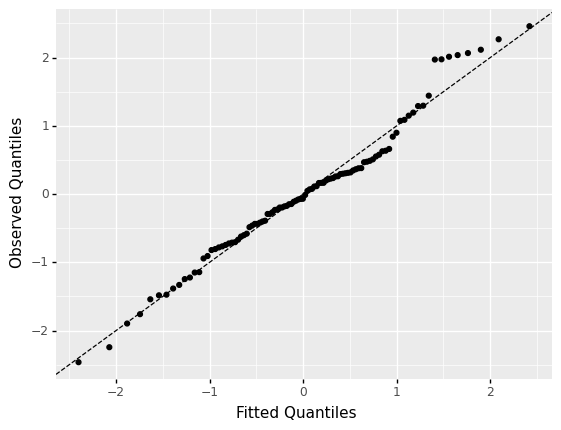

<ggplot: (8758213920317)>

In [9]:
## NOTE: No need to edit; run and inspect
# Define a standard normal distribution
mg_norm = gr.marg_mom("norm", mean=0, sd=1)

(
    # Draw some random values
    gr.df_make(z=mg_norm.r(100))
    # Compute theoretical quantiles based on fitted normal
    >> gr.tf_mutate(q=gr.qqvals(DF.z, "norm"))
    
    # Visualize
    >> gr.ggplot(gr.aes("q", "z"))
    # Add a guideline
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    
    + gr.geom_point()
    + gr.labs(x="Fitted Quantiles", y="Observed Quantiles")
)

*Observations*

- How "straight" do the observations appear?
  - Quite straight, but not perfect! Note that the observations are a bit "jittered" in the middle, and and fall progressively far from the line $y=x$ at the tails of the distribution.
Keep in mind that this is what a *perfectly chosen* distribution will look like on a QQ plot; the plot above (with all of its imperfections) is what the *best possible* fit will look like!


### __q6__ Fit a distribution for the `tensile_strength`

Pick a distribution from the list of "reasonable" distributions you generated in `__q3__ Select reasonable distributions`, and fit a distribution for `df_shewhart.tensile_strength`. Answer the questions under *observations* below.

*Hint*: If you choose to fit a `"lognorm"` or `"weibull_min"`, you may find it helpful to set the keyword argument `floc=0` to use the 2-parameter version of the distribution. Anecdotally, I find the 2-parameter version to be more stable for small datasets.


/home/zach/Git/py_grama/grama/tran_pivot.py:570: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


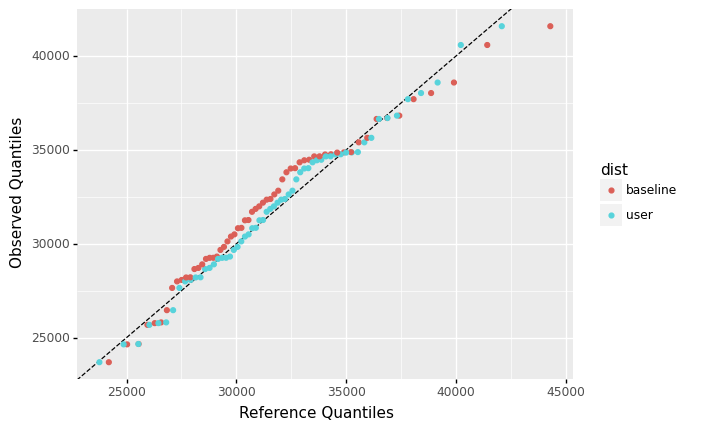

<ggplot: (8758213873267)>

In [10]:
# TASK: Fit a distribution for the tensile_strength;
# assign it to mg_user below

mg_user = gr.marg_fit(
    "lognorm", 
    df_shewhart.tensile_strength,
    floc=0,
)
# NOTE: Don't edit this; use to check your results
mg_base = gr.marg_fit(
    "gengamma",
    df_shewhart.tensile_strength,
    floc=0,
)

(
    df_shewhart
    >> gr.tf_mutate(
        q_baseline=gr.qqvals(DF.tensile_strength, marg=mg_base),
        q_user=gr.qqvals(DF.tensile_strength, marg=mg_user),
    )
    >> gr.tf_pivot_longer(
        columns=gr.contains("q_"),
        names_to=[".value", "dist"],
        names_sep="_",
    )
    
    >> gr.ggplot(gr.aes("q", "tensile_strength", color="dist"))
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    + gr.geom_point()
    + gr.labs(x="Reference Quantiles", y="Observed Quantiles")
)

*Observations*

- What distribution did you choose to fit?
  - I fit a lognormal `"lognorm"` distribution, but there are multiple reasonable choices for this question.
- How does your distribution (`user`) compare with the generalized gamma distribution (`base`)?
  - The lognormal fits a fair bit better than the generalized gamma; both the middle of the distribution and the right tail lie closer to the identity line.
<!-- solution-end -->

# Use the model

Once we've fit a distribution, we can use it to do useful work! We'll discuss this further in a future exercise, but we'll do a quick tour below.


## Beyond assuming the mean

Above, we saw that simply using the mean of `tensile_strength` for design was dangerous for safety-critical applications. Let's talk about a more principled way to address the variability in `tensile_strength`.

For a simple structural member subject to uniaxial tension, we can define its *limit state function $g$ via

$$g_{\text{tension}} = S - F/A,$$

where $S$ is the strength, $F$ is the applied tensile load, and $A$ is the cross-sectional area. The limit state models the failure criterion; when $g > 0$ the structure operates safely, while $g \leq 0$ corresponds to failure. The following code implements a grama model with this function, uses **your** model for the `tensile_strength`, and defines a distribution for an uncertain load:


In [11]:
## NOTE: No need to edit
md_structure = (
    gr.Model("Uniaxial tension member")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            g_tension=df.S - df.F / df.A,
        ),
        var=["S", "F", "A"],
        out=["g_tension"],
    )
    >> gr.cp_bounds(A=(1.0, 5.0))
    >> gr.cp_marginals(
        S=mg_user,
        F=gr.marg_mom("lognorm", mean=8e4, cov=0.1, floc=0),
    )
    >> gr.cp_copula_independence()
)
md_structure

model: Uniaxial tension member

  inputs:
    var_det:
      A: [1.0, 5.0]

    var_rand:
      S: (+0) lognorm, {'mean': '3.187e+04', 's.d.': '4.019e+03', 'COV': 0.13, 'skew.': 0.38, 'kurt.': 3.26}
      F: (+0) lognorm, {'mean': '8.000e+04', 's.d.': '8.000e+03', 'COV': 0.1, 'skew.': 0.3, 'kurt.': 3.16}

    copula:
      Independence copula

  functions:
      f0: ['S', 'F', 'A'] -> ['g_tension']

We can use this model to assess the probability of failure of several values of $A$, to help inform a design decision.


### __q7__ Evaluate the model

Draw a random sample from `md_structure` at different values of the cross-sectional area `A`. Answer the questions under *observations* below.


In [12]:
## TASK: Evaluate a random sample
(
    md_structure

    >> gr.ev_sample(n=1e3, df_det=gr.df_make(A=[2, 3, 4]))
    
    ## NOTE: No need to edit; use this to analyze the random sample
    >> gr.tf_group_by(DF.A)
    >> gr.tf_summarize(
        pof_lo=gr.binomial_ci(DF.g_tension <= 0, alpha=0.95, side="lo"),
        pof_mu=gr.mean(DF.g_tension <= 0),
        pof_up=gr.binomial_ci(DF.g_tension <= 0, alpha=0.95, side="up"),
    )
)

eval_sample() is rounding n...


,A,pof_lo,pof_mu,pof_up
0,2,0.924476,0.925,0.925521
1,3,0.157278,0.158,0.158725
2,4,0.002893,0.003,0.003110


*Observations*

- Can you find a value of `A` where you can *confidently* say the probability of failure (pof) is `pof < 0.01`?
  - Yes; I find `pof < 0.01` for `A == 4` (at `n=1e3`); one could probably get away with a slightly smaller value of `A` as well.
<!-- solution-end -->